In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai-201-b-mse-2-ai-a/sample_submission.csv
/kaggle/input/ai-201-b-mse-2-ai-a/train.csv
/kaggle/input/ai-201-b-mse-2-ai-a/test.csv


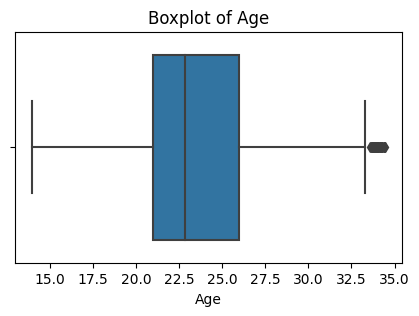

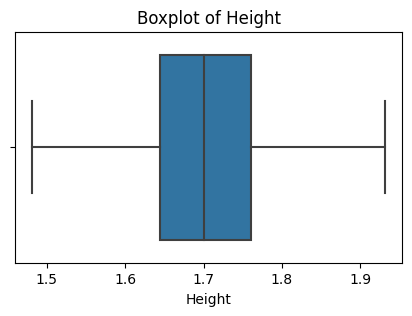

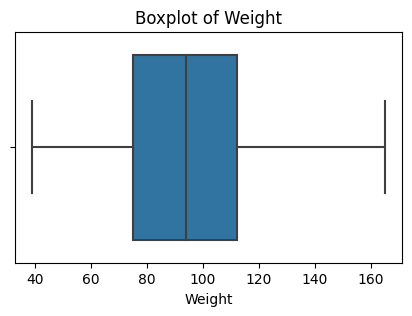

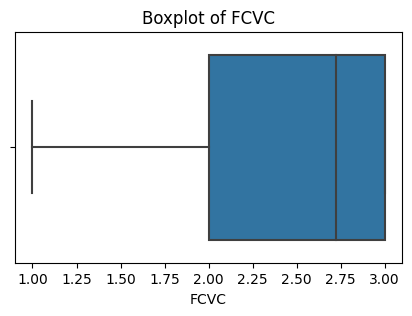

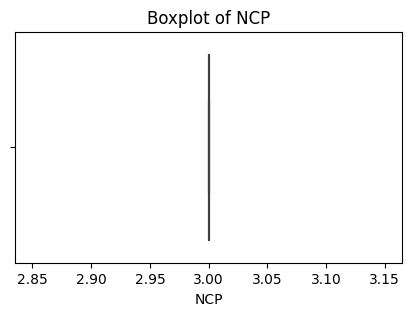

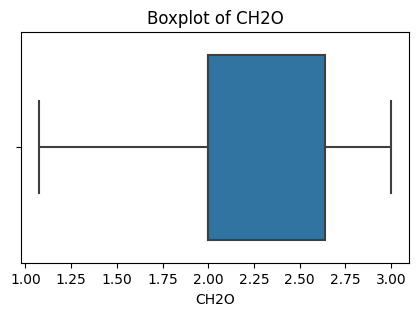

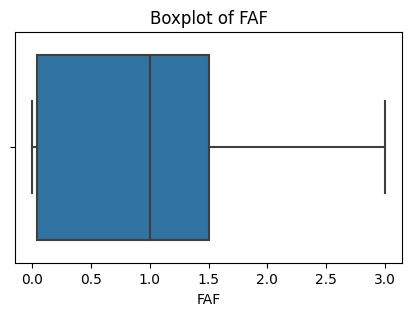

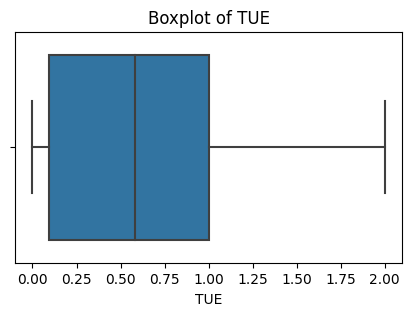

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


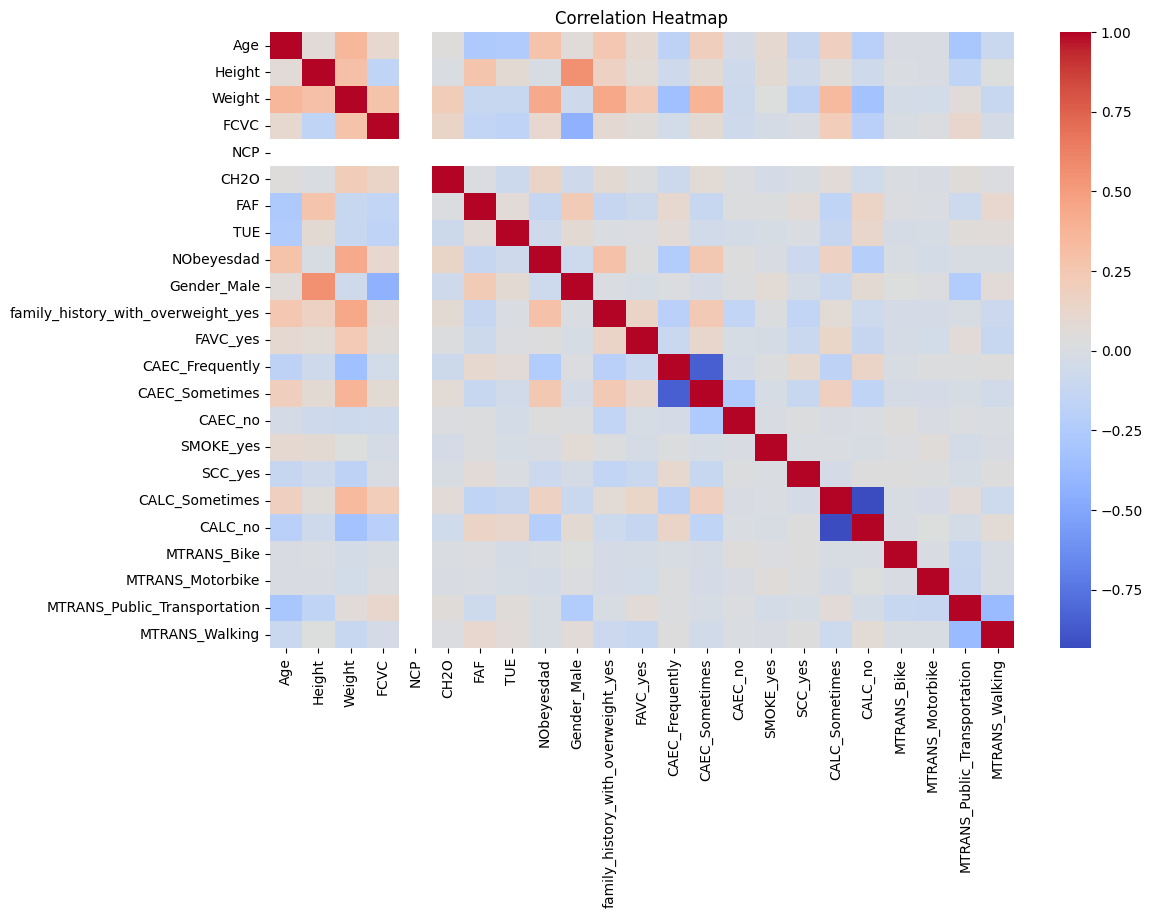

Accuracy: 0.8677119059284665

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.82      0.86       199
           1       0.76      0.85      0.81       309
           2       0.80      0.87      0.83       215
           3       0.97      0.96      0.96       311
           4       0.99      1.00      1.00       585
           5       0.74      0.61      0.67       212
           6       0.70      0.69      0.69       210

    accuracy                           0.87      2041
   macro avg       0.84      0.83      0.83      2041
weighted avg       0.87      0.87      0.87      2041

Best Params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Test predictions saved to final_predictions.csv


In [2]:
# -------------------------------------------
# IMPORTS
# -------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# -------------------------------------------
# LOAD DATA
# -------------------------------------------
train = pd.read_csv("/kaggle/input/ai-201-b-mse-2-ai-a/train.csv")
test = pd.read_csv("/kaggle/input/ai-201-b-mse-2-ai-a/test.csv")

# -------------------------------------------
# REMOVE DUPLICATE ROWS
# -------------------------------------------
train = train.drop_duplicates()

# -------------------------------------------
# IDENTIFY COLUMN TYPES
# -------------------------------------------
num_cols = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
cat_cols = [
    "Gender",
    "family_history_with_overweight",
    "FAVC",
    "CAEC",
    "SMOKE",
    "SCC",
    "CALC",
    "MTRANS"
]

# -------------------------------------------
# HANDLE MISSING VALUES
# NUMERIC → MEDIAN
# CATEGORICAL → MODE
# -------------------------------------------
for col in num_cols:
    train[col] = train[col].fillna(train[col].median())
    test[col] = test[col].fillna(train[col].median())


for col in cat_cols:
    train[col] = train[col].fillna(train[col].mode()[0])
    test[col] = test[col].fillna(train[col].mode()[0])


# -------------------------------------------
# IQR OUTLIER HANDLING (REMOVE ROWS OUTSIDE IQR)
# -------------------------------------------
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]
    return df_clean

train = remove_outliers_iqr(train, num_cols)

# -------------------------------------------
# BOXPLOTS
# -------------------------------------------
for col in num_cols:
    plt.figure(figsize=(5, 3))
    sns.boxplot(x=train[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

# -------------------------------------------
# LABEL ENCODE TARGET
# -------------------------------------------
le = LabelEncoder()
train["NObeyesdad"] = le.fit_transform(train["NObeyesdad"])

# -------------------------------------------
# ONE-HOT ENCODING
# -------------------------------------------
train = pd.get_dummies(train, columns=cat_cols, drop_first=True)
test = pd.get_dummies(test, columns=cat_cols, drop_first=True)

# Align test with train
test = test.reindex(columns=train.drop("NObeyesdad", axis=1).columns, fill_value=0)

# -------------------------------------------
# TRAIN/VAL SPLIT
# -------------------------------------------
X = train.drop("NObeyesdad", axis=1)
y = train["NObeyesdad"]

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -------------------------------------------
# SCALING
# -------------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test)

# -------------------------------------------
# CORRELATION HEATMAP
# -------------------------------------------
plt.figure(figsize=(12, 8))
sns.heatmap(train.corr(), cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# -------------------------------------------
# RANDOM FOREST MODEL
# -------------------------------------------
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_scaled, y_train)

y_pred = rf.predict(X_val_scaled)
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))

# -------------------------------------------
# HYPERPARAMETER TUNING
# -------------------------------------------
params = {
    "n_estimators": [100, 200, 300],
    "max_depth": [5, 10, 15, None],
    "min_samples_split": [2, 5, 10]
}

grid = GridSearchCV(
    rf,
    param_grid=params,
    cv=3,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)
print("Best Params:", grid.best_params_)

best_model = grid.best_estimator_

# -------------------------------------------
# FINAL TEST PREDICTIONS
# -------------------------------------------
test_preds = best_model.predict(test_scaled)

test_output = pd.DataFrame({
    "Predicted_NObeyesdad": le.inverse_transform(test_preds)
})

test_output.to_csv("final_predictions.csv", index=False)

print("Test predictions saved to final_predictions.csv")
